## Data Preparation

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
path = "../dataset/malimg_paper_dataset_imgs"
batches = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64),batch_size = 10000)


Found 9339 images belonging to 25 classes.


In [3]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [4]:
imgs, labels = next(batches)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

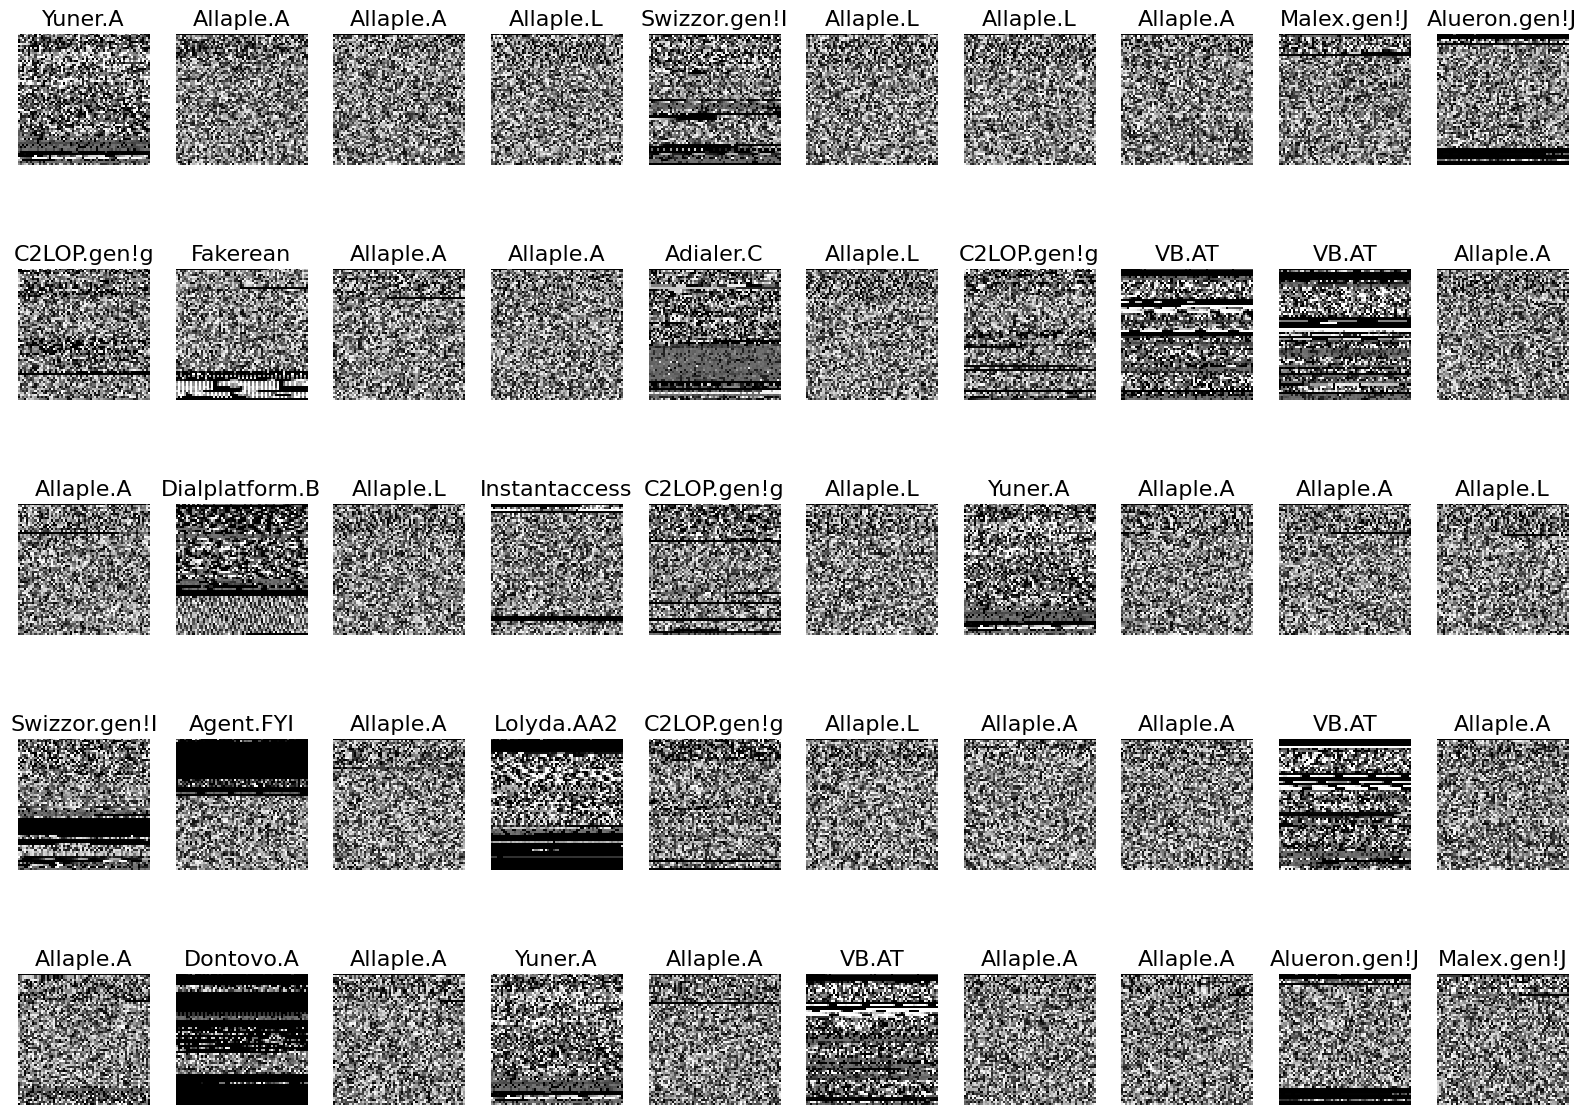

In [6]:
plots(imgs, titles = labels)


In [7]:
classes = batches.class_indices.keys()

In [8]:
perc = (sum(labels)/labels.shape[0])*100

<BarContainer object of 25 artists>

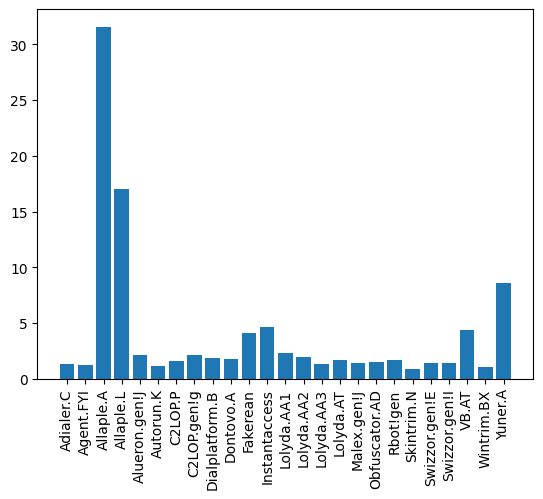

In [9]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

Here i used class weights technique, <br>sklearn.utilis.class_weights function uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. To use this method, y_train must not be one-hot encoded.
<br>This method gives less weights to frequently appearing classes and more weights to less occuring classes on its own while computing of forward and backward propogation.




## Building the model

In [12]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input

from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [15]:
X_train.shape

(6537, 64, 64, 3)

In [16]:
X_test.shape

(2802, 64, 64, 3)

In [17]:
y_train.shape

(6537, 25)

In [18]:
y_test.shape

(2802, 25)

In [19]:
num_classes = 25

In [21]:
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [22]:
Malware_model = malware_model()
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 15)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 15)        0         
                                                                 
 flatten (Flatten)           (None, 2940)              0

In [23]:
y_train.shape

(6537, 25)

## Handling Imbalances in classes

In [24]:
import numpy as np
y_train_new = np.argmax(y_train, axis=1)


In [25]:
y_train_new

array([ 2, 17,  3, ...,  2,  2,  3], dtype=int64)

In [26]:
from sklearn.utils import class_weight
#Deal with unbalanced Data
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_new),
                                                 y_train_new)


In [27]:
class_weights.dtype

dtype('float64')

In [28]:
keys = [x for x in range(26)]
  

In [29]:
mydict = {k:v for(k,v) in zip(keys,class_weights)}

## Fitting the model

In [30]:
Malware_model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=15,class_weight=mydict)

Epoch 1/15
205/205 [==============================] - 10s 46ms/step - loss: 1.9887 - accuracy: 0.3430 - val_loss: 1.1694 - val_accuracy: 0.4140
Epoch 2/15
205/205 [==============================] - 9s 45ms/step - loss: 0.9657 - accuracy: 0.4996 - val_loss: 0.9240 - val_accuracy: 0.5396
Epoch 3/15
205/205 [==============================] - 9s 45ms/step - loss: 0.7003 - accuracy: 0.5643 - val_loss: 0.7510 - val_accuracy: 0.6113
Epoch 4/15
205/205 [==============================] - 9s 46ms/step - loss: 0.5720 - accuracy: 0.6104 - val_loss: 0.6495 - val_accuracy: 0.6642
Epoch 5/15
205/205 [==============================] - 9s 46ms/step - loss: 0.5182 - accuracy: 0.6397 - val_loss: 0.6664 - val_accuracy: 0.6338
Epoch 6/15
205/205 [==============================] - 10s 47ms/step - loss: 0.4412 - accuracy: 0.6821 - val_loss: 0.5601 - val_accuracy: 0.7302
Epoch 7/15
205/205 [==============================] - 10s 48ms/step - loss: 0.3968 - accuracy: 0.7188 - val_loss: 0.5337 - val_accuracy: 0.6

## Evaluating the model with X_test and y_test

In [31]:
scores = Malware_model.evaluate(X_test, y_test)

88/88 [==============================] - 1s 12ms/step - loss: 0.1964 - accuracy: 0.9497


In [32]:
print('Final CNN accuracy: ', scores[1])

Final CNN accuracy:  0.9496787786483765


In [33]:
import pandas as pd


In [47]:
predict_x=Malware_model.predict(X_test) 
y_pred=np.argmax(predict_x,axis=1)

88/88 [==============================] - 1s 12ms/step


In [48]:
print(y_pred)

[15  0  4 ...  6 11 24]


In [49]:
y_test2 = np.argmax(y_test, axis=1)

In [50]:
y_test2

array([15,  0,  4, ...,  6, 11, 24], dtype=int64)

## Plotting the confusion matrix

In [51]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test2, y_pred)
Malware_model.save('../components2/Malware_model2.h5')

In [54]:

import seaborn as sns
import matplotlib.pyplot as plt

def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

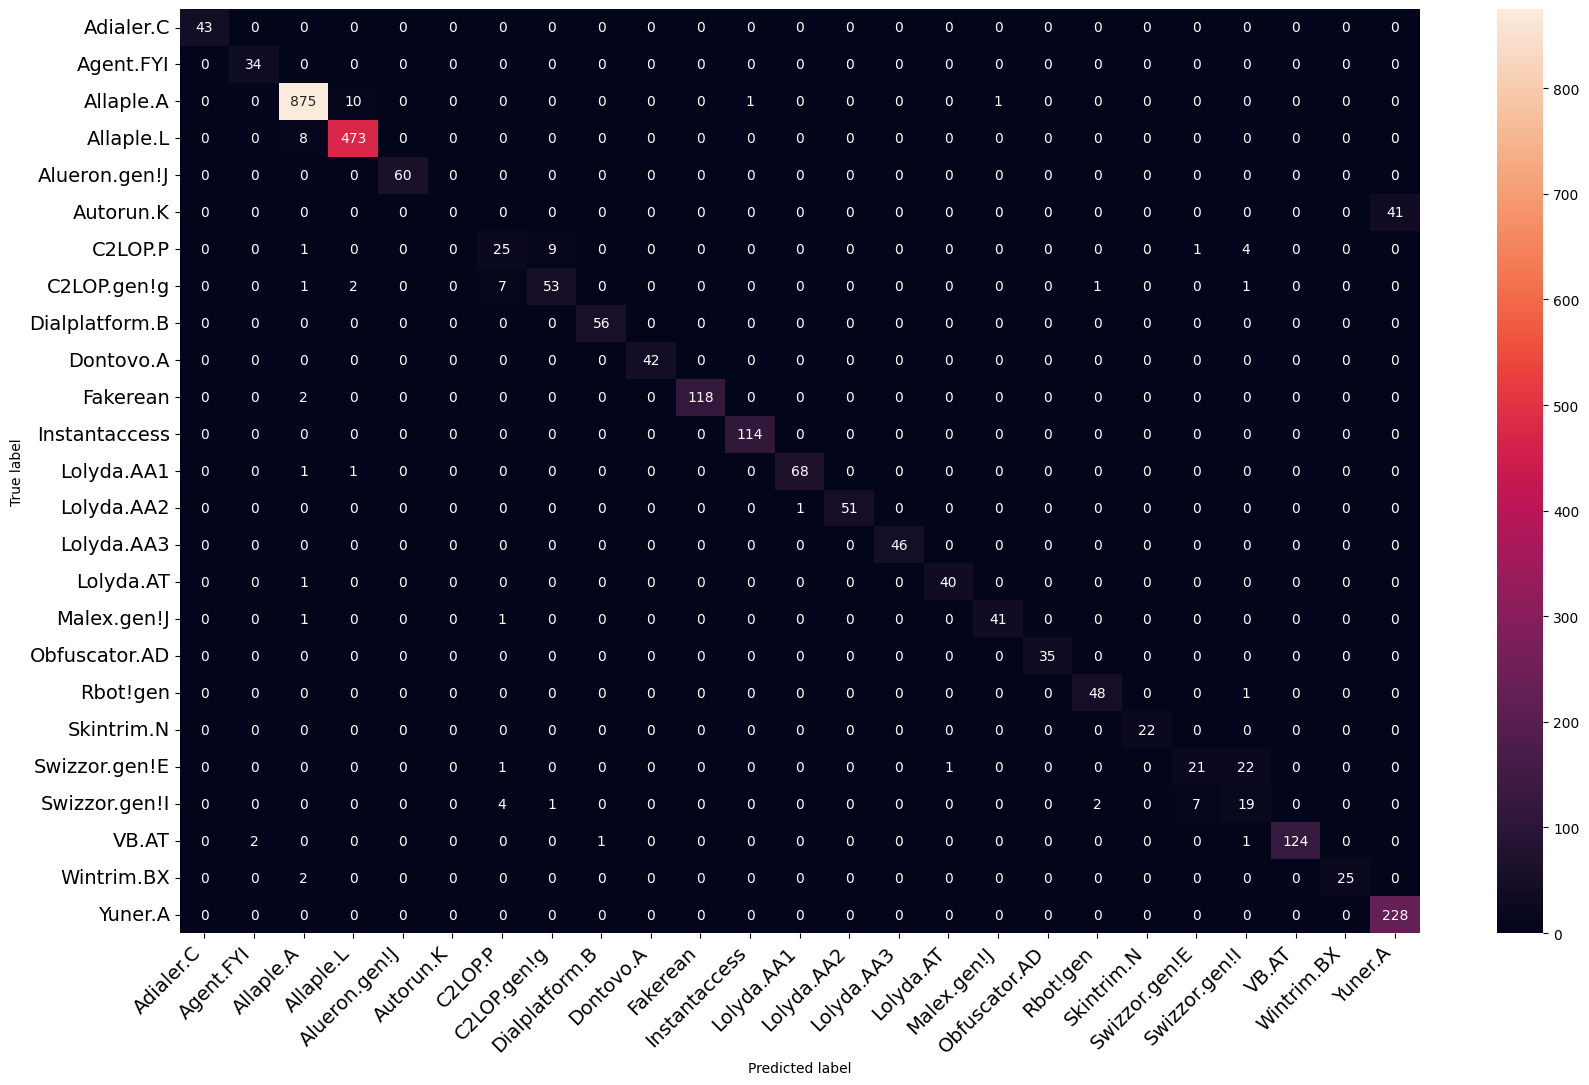

In [55]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,12), fontsize=14)